In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import json
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1
#----------Hyper Parameters----------#
hidden_size = 256
#The number of vocabulary
vocab_size = 30 #29
learning_rate = 0.1
teacher_forcing_ratio = 1.0
MAX_LENGTH = 19
# torch.manual_seed(1236)

In [3]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %2s)' % (asMinutes(s), asMinutes(rs))

#### Show loss

In [4]:
def show_result(score, loss):  
    plt.figure(figsize=(10, 6))
    
    plt.ylabel("Score")
    plt.xlabel("Epochs")
    plt.title("BLEU Score Curve", fontsize=18)
    plt.plot(score)

    plt.show()
    
    plt.figure(figsize=(10, 6))
    
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss Curve", fontsize=18)
    plt.plot(loss)

    plt.show()

#### BLEU

In [5]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

#### Get data

In [40]:
def getData(mode):
    assert mode == 'train' or mode == 'test' or mode == 'new_test'
    dataset = json.load(open('./data/'+mode+'.json', 'r'))
    inputs = []
    labels = []
    for data in dataset:
        inputs.append(data['input'])
        labels.append(data['target'])
    return inputs, labels

### Build vocabulary

In [7]:
class Vocabuary():
    def __init__(self):
        self.word2index = {'SOS': 0, 'EOS': 1, 'PAD': 2, 'UNK': 3}
        self.index2word = {0: 'SOS', 1: 'EOS', 2: 'PAD', 3: 'UNK'}
        self.n_words = 4
        self.max_length = 0
        self.build_vocab(geTtData('train')[0])
        

    # input the training data and build vocabulary
    def build_vocab(self, corpus):
        for words in corpus:
            for word in words:
                if len(word) > self.max_length:
                    self.max_length = len(word)
                    
                for char in word:
                    if char not in self.word2index:
                        self.word2index[char] = self.n_words
                        self.index2word[self.n_words] = char
                        self.n_words += 1                      
                    
    # convert word in indices
    def word2indices(self, word, add_eos=False, add_sos=False):
        indices = [self.word2index[char] if char in self.word2index else 3 for char in word]

        if add_sos:
            indices.insert(0, 0)
        if add_eos:
            indices.append(1)
            
        # padding input of same target into same length
        indices.extend([2]*(self.max_length-len(word)))
            
        return np.array(indices)
    
    # convert indices to word
    def indices2word(self, indices):
        word = [self.index2word[idx] for idx in indices if idx > 2 ]
        return ''.join(word)

In [8]:
t = "hello"
idx = v.word2indices(t)
print(idx)
t = v.indices2word(idx)
print(t)

[20  6 12 12 17  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
hello


### Data Loader

In [9]:
class SpellingLoader(data.Dataset):
    def __init__(self, mode, vocab):
        self.mode = mode   
        self.inputs, self.targets = self.convert_pair()
        self.vocab = vocab
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input = torch.tensor(self.vocab.word2indices(self.inputs[index]))
        target = torch.tensor(self.vocab.word2indices(self.targets[index]))
        return input, target
    
    # convert (multi-input)+target into multi-(input+target) pair
    def convert_pair(self):
        input_data, label_data = getData(self.mode)
        inputs_list = []
        labels_list = []
        for inputs, label in zip(input_data, label_data):
            for input in inputs:
                inputs_list.append(input)
                labels_list.append(label)
        return inputs_list, labels_list                

In [10]:
vocab = Vocabuary()
trainset = SpellingLoader('train', vocab)
testset = SpellingLoader('test', vocab)

In [11]:
trainset[16]

(tensor([ 6, 14, 15, 21, 17, 17, 19,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2]),
 tensor([ 6,  4, 14, 15, 21, 17, 17, 19,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2]))

### Encoder
Input (1, batch_size)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, -1, self.hidden_size)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=32):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

### Decoder
Input (1, batch_size)

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, -1, self.hidden_size)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self, batch_size=32):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

#### Train

In [14]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, teacher_forcing_ratio, max_length=MAX_LENGTH):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    # transpose tensor from (batch_size, seq_len) to (seq_len, batch_size)
    input_tensor = input_tensor.transpose(0, 1)
    target_tensor = target_tensor.transpose(0, 1)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # calculate number of time step
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    loss = 0

    #----------sequence to sequence part for encoder----------#
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token] for i in range(batch_size)], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
	

    #----------sequence to sequence part for decoder----------#
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden) 
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden) 
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### Train iteration

In [31]:
def trainIters(encoder, decoder, vocab, n_iters, print_every=1000, plot_every=100, 
               batch_size=32, learning_rate=0.01, teacher_forcing_ratio=1.0):
    start = time.time()
    plot_losses = []
    plot_scores = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # create dataloader
    trainset = SpellingLoader('train', vocab)
    trainloader = data.DataLoader(trainset, batch_size, shuffle = True)

    criterion = nn.CrossEntropyLoss()
    
    max_score = 0.8

    for iter in range(1, n_iters + 1):
        for input_tensor, target_tensor in trainloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio)
            print_loss_total += loss
            plot_loss_total += loss
            
        # evaluate and save model
        _, avg_bleu = evaluate(encoder, decoder, vocab)
        plot_scores.append(avg_bleu)
        if avg_bleu > max_score:
            max_score = avg_bleu
            print ("Model save...")
            torch.save(encoder, "./models/encoder_{:.4f}.ckpt".format(avg_bleu))
            torch.save(decoder, "./models/decoder_{:.4f}.ckpt".format(avg_bleu))

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) Loss: %.4f BLEU: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, avg_bleu))
 
        plot_losses.append(plot_loss_total)
        plot_loss_total = 0
            
    #print ("The highest score is %s"%max_score)
            
    return plot_scores, plot_losses

#### Evaluate

In [16]:
# print the prediction and return the bleu score
def show_prediction(inputs, prediction, targets, plot_pred):

    bleu_total = 0
    for idx in range(len(inputs)):
        bleu_total += compute_bleu(prediction[idx], targets[idx])

        if plot_pred:
            output = "\ninput:  {}\ntarget: {}\npred:   {}".format(inputs[idx], targets[idx], prediction[idx])
            print ("="*30+output)

    return bleu_total/len(inputs)

In [41]:
def evaluate(encoder, decoder, vocab, batch_size=32, plot_pred=False):
    # create dataloader
    testset = SpellingLoader('test', vocab)
    testloader = data.DataLoader(testset, batch_size=32)
        
    prediction = []
    targets = []
    inputs = []

    with torch.no_grad():    
        for input_tensor, target_tensor in testloader:
            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)
            
            # convert input&target into string
            for idx in range(batch_size):
                targets.append(vocab.indices2word(target_tensor[idx].data.numpy()))
                inputs.append(vocab.indices2word(input_tensor[idx].data.numpy()))

            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)
            
            # transpose tensor from (batch_size, seq_len) to (seq_len, batch_size)
            input_tensor = input_tensor.transpose(0, 1)
            target_tensor = target_tensor.transpose(0, 1)

            # calculate number of time step
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            
            #----------sequence to sequence part for encoder----------#
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
        
            decoder_input = torch.tensor([SOS_token for i in range(batch_size)], device=device)
            output = torch.zeros(target_length, batch_size)
            
            decoder_hidden = encoder_hidden
            
            #----------sequence to sequence part for decoder----------#
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input
                output[di] = decoder_input

            # get predict indices
            output = output.transpose(0, 1)    
                
            # convert indices into string
            for idx in range(batch_size):
                prediction.append(vocab.indices2word(output[idx].data.numpy()))
                
        # calculate average BLEU score
        avg_bleu = show_prediction(inputs, prediction, targets, plot_pred)
                
        return prediction, avg_bleu

#### main

0m 44s (- 6m 37s) (10 10%) Loss: 229.2186 BLEU: 0.0693
1m 25s (- 5m 41s) (20 20%) Loss: 190.3960 BLEU: 0.1178
2m 6s (- 4m 55s) (30 30%) Loss: 150.5126 BLEU: 0.2589
2m 47s (- 4m 11s) (40 40%) Loss: 115.2383 BLEU: 0.3573
3m 29s (- 3m 29s) (50 50%) Loss: 93.8579 BLEU: 0.3942
4m 10s (- 2m 47s) (60 60%) Loss: 80.3520 BLEU: 0.4996
4m 51s (- 2m 4s) (70 70%) Loss: 69.8870 BLEU: 0.5667
5m 32s (- 1m 23s) (80 80%) Loss: 63.2769 BLEU: 0.6198
6m 13s (- 0m 41s) (90 90%) Loss: 57.5642 BLEU: 0.6260
6m 55s (- 0m 0s) (100 100%) Loss: 52.1622 BLEU: 0.6909
The highest score is 0.7988


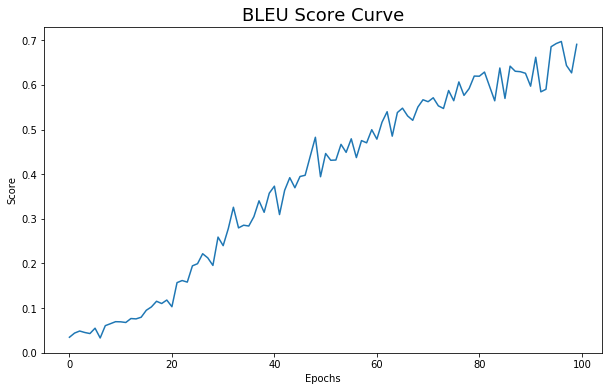

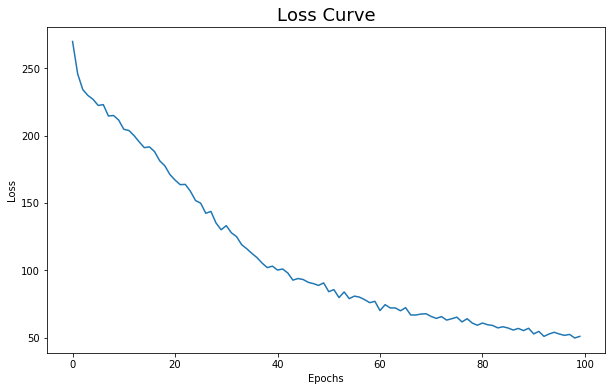

In [33]:
encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, vocab_size).to(device)
vocab = Vocabuary()
scores, losses = trainIters(encoder1, decoder1, vocab, 100, print_every=10, plot_every=1, teacher_forcing_ratio=1)
show_result(scores, losses)

In [30]:
predictions, avg_bleu = evaluate(encoder1, decoder1, vocab, plot_pred=True)
print ("BLEU-4 score: %.4f"%avg_bleu)

input:  contenpted
target: contented
pred:   contented
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juce
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transporatibility
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   partyry
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   tringulaal
input:  unexpcted
target: unexpected
pred:   unexpected
input:  stanerdizing
target: standardizing
pred:   st